# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: [Dies Natalis Solis Invicti](https://en.wikipedia.org/wiki/Sol_Invictus)
* Reviews: [Befana](https://en.wikipedia.org/wiki/Befana)

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [90]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [91]:
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1  # Player 1 starts the game

    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1
        return self.board.flatten()

    def step(self, action):
        x, y = divmod(action, 3)
        if self.board[x, y] != 0:
            # Invalid move, negative reward
            # Useful when playing with keyboard input
            return self.board.flatten(), -10, True

        self.board[x, y] = self.current_player

        if self.check_winner(self.current_player):
            # Current player wins
            return self.board.flatten(), 1, True

        if np.all(self.board != 0):
            # Draw
            return self.board.flatten(), 0.5, True

        # Change player
        self.current_player = 3 - self.current_player
        return self.board.flatten(), 0, False

    def check_winner(self, player):
        # Check rows and columns 
        for i in range(3):
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return True
        # Check the diagonals
        if np.all(np.diag(self.board) == player) or np.all(np.diag(np.fliplr(self.board)) == player):
            return True
        return False

    def valid_actions(self):
        return [i for i in range(9) if self.board.flatten()[i] == 0]

    def render(self):
        symbols = {0: '_', 1: 'X', 2: 'O'}
        for row in self.board:
            print(' '.join(symbols[i] for i in row))
        print()

# Test the TicTacToe class
game = TicTacToe()
game.reset()
game.render()  # Display the empty board

_ _ _
_ _ _
_ _ _



In [92]:
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1):
        # Instead of using a 2D matrix, the q_table is implemented as a dictionary where the keys are tuples representing states, 
        # and the values are arrays that represent the Q values associated with possible actions in the corresponding state.
        self.q_table = defaultdict(lambda: np.zeros(9))
        self.alpha = alpha    # Learning rate
        self.gamma = gamma    # Discount factor
        self.epsilon = epsilon # Exploration rate

    def choose_action(self, state, valid_actions):
        if random.uniform(0, 1) < self.epsilon:
            # Explore: choose a random valid action
            return random.choice(valid_actions)
        else:
            # Exploit: choose the best action based on current Q-values
            # If not present the state as a key in the dict, it will be created
            q_values = self.q_table[state]
            max_q_value = np.max(q_values[valid_actions])
            max_actions = [a for a in valid_actions if q_values[a] == max_q_value]
            return random.choice(max_actions)

    def learn(self, state, action, reward, next_state, next_valid_actions, done):
        # Represents the current Q value for the "action" in the "state"
        old_value = self.q_table[state][action]

        # Represents the maximum estimated Q value for valid actions in the "next_state"
        future_q = 0 if done else np.max(self.q_table[next_state][next_valid_actions])
        
        # Bellman Equation: Q(s,a)←(1−α)⋅Q(s,a)+α⋅(r+γ⋅maxQ(s′,a′))
        # where Q(s,a) is the current Q value for state s and action a
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * future_q)
        self.q_table[state][action] = new_value

def train_agent(episodes=1000):
    agent = QLearningAgent()
    env = TicTacToe()
    
    for episode in range(episodes):
        state = env.reset()
        done = False

        while not done:
            valid_actions = env.valid_actions()
            action = agent.choose_action(tuple(state), valid_actions)
            next_state, reward, done = env.step(action)
            next_valid_actions = env.valid_actions()
            agent.learn(tuple(state), action, reward, tuple(next_state), next_valid_actions, done)
            state = next_state

    return agent

# Train the agent
trained_agent = train_agent(episodes=1000)

In [93]:
def evaluate_agent(agent, games=100):
    env = TicTacToe()
    results = {"Wins": 0, "Losses": 0, "Draws": 0}

    for game in range(games):
        state = env.reset()
        done = False
        while not done:
            # Agent's turn
            valid_actions = env.valid_actions()
            action = agent.choose_action(tuple(state), valid_actions)
            state, reward, done = env.step(action)
            if game==0: env.render()    # just for fun 

            if done:
                if reward == 1:  # Agent wins
                    results["Wins"] += 1
                elif reward == 0.5:  # Draw
                    results["Draws"] += 1
                break

            # Random player's turn (opponent)
            valid_actions = env.valid_actions()
            action = random.choice(valid_actions)
            state, reward, done = env.step(action)
            if game==0: env.render()

            if done:
                if reward == -10:  # Agent wins (opponent made invalid move)
                    results["Wins"] += 1
                elif reward == 1:  # Opponent wins
                    results["Losses"] += 1
                elif reward == 0.5:  # Draw
                    results["Draws"] += 1

    return results  # Return results and all game moves as a tuple

# Evaluate the trained agent
evaluation_results = evaluate_agent(trained_agent, games=100)
evaluation_results

_ X _
_ _ _
_ _ _

_ X _
_ _ _
_ _ O

_ X _
_ X _
_ _ O

_ X _
_ X O
_ _ O

_ X _
_ X O
_ X O



{'Wins': 65, 'Losses': 29, 'Draws': 6}

## Cross Validation

In [94]:
def cross_validate_agents(alphas, gammas, epsilons, episodes=1000, games=100):
    results = []
    for alpha in alphas:
        for gamma in gammas:
            for epsilon in epsilons:
                # Train the agent
                agent = QLearningAgent(alpha=alpha, gamma=gamma, epsilon=epsilon)
                env = TicTacToe()
                for _ in range(episodes):
                    state = env.reset()
                    done = False

                    while not done:
                        valid_actions = env.valid_actions()
                        action = agent.choose_action(tuple(state), valid_actions)
                        next_state, reward, done = env.step(action)
                        next_valid_actions = env.valid_actions()
                        agent.learn(tuple(state), action, reward, tuple(next_state), next_valid_actions, done)
                        state = next_state

                # Evaluate the agent
                evaluation_results = evaluate_agent(agent, games=games)

                # Store the results
                results.append({
                    'alpha': alpha,
                    'gamma': gamma,
                    'epsilon': epsilon,
                    'evaluation': evaluation_results,
                    'agent': agent
                })

    return results

# Example usage
alphas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]
epsilons = [0.1, 0.2, 0.3]

cross_validation_results = cross_validate_agents(alphas, gammas, epsilons)
#cross_validation_results

X _ _
_ _ _
_ _ _

X _ _
_ _ O
_ _ _

X _ _
_ _ O
X _ _

X _ _
_ _ O
X O _

X X _
_ _ O
X O _

X X _
O _ O
X O _

X X _
O X O
X O _

X X O
O X O
X O _

X X O
O X O
X O X

_ _ _
_ _ _
X _ _

_ _ _
_ O _
X _ _

_ _ _
_ O _
X X _

_ O _
_ O _
X X _

_ O _
_ O _
X X X

_ _ _
X _ _
_ _ _

_ _ _
X O _
_ _ _

_ _ _
X O X
_ _ _

_ _ _
X O X
O _ _

X _ _
X O X
O _ _

X _ _
X O X
O O _

X X _
X O X
O O _

X X O
X O X
O O _

_ _ _
_ _ _
X _ _

_ O _
_ _ _
X _ _

_ O _
X _ _
X _ _

_ O _
X _ O
X _ _

X O _
X _ O
X _ _

_ _ _
_ X _
_ _ _

_ _ _
_ X _
_ O _

X _ _
_ X _
_ O _

X _ _
O X _
_ O _

X X _
O X _
_ O _

X X _
O X _
_ O O

X X X
O X _
_ O O

_ X _
_ _ _
_ _ _

_ X _
_ _ _
_ O _

_ X X
_ _ _
_ O _

_ X X
_ O _
_ O _

_ X X
_ O X
_ O _

O X X
_ O X
_ O _

O X X
_ O X
_ O X

_ X _
_ _ _
_ _ _

O X _
_ _ _
_ _ _

O X _
_ _ _
X _ _

O X _
_ _ _
X _ O

O X _
_ _ _
X X O

O X _
_ O _
X X O

_ X _
_ _ _
_ _ _

_ X _
_ _ _
O _ _

_ X _
_ _ _
O X _

_ X O
_ _ _
O X _

_ X O
_ X _
O X _

_ _ _
_ X _


## Print the Stats

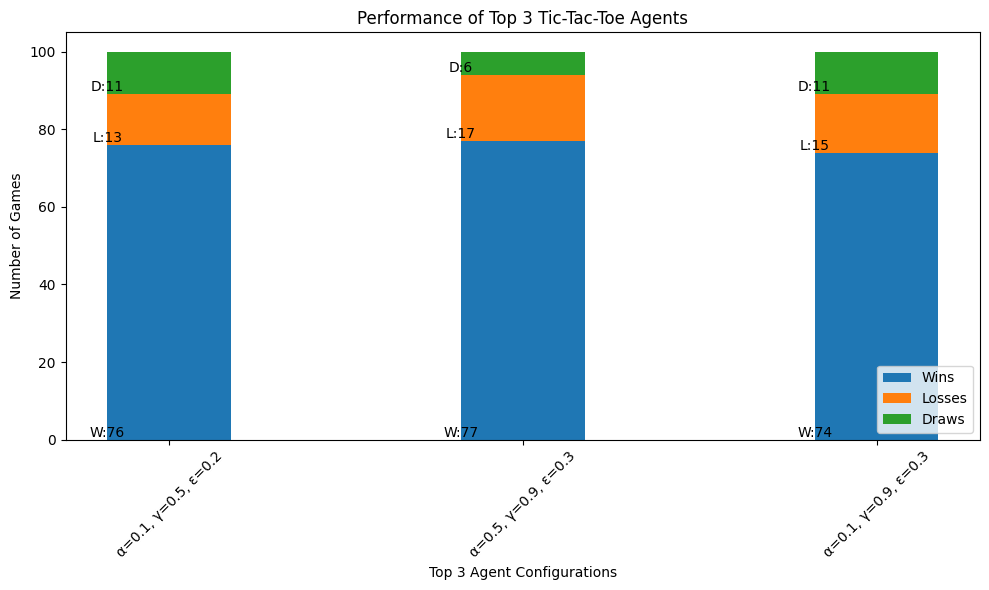

In [95]:
# Prepare the data with sorting
# Calculate the difference between wins and losses for each configuration
performance = [result['evaluation']['Wins'] - result['evaluation']['Losses'] for result in cross_validation_results]
# Add performance to the results for sorting
for i, result in enumerate(cross_validation_results):
    result['performance'] = performance[i]

# Sort the results by performance and select the top 3
top_results = sorted(cross_validation_results, key=lambda x: x['performance'], reverse=True)[:3]
top_agent = top_results[0]['agent']

# Extract data for the top 3 configurations
alphas = [result['alpha'] for result in top_results]
gammas = [result['gamma'] for result in top_results]
epsilons = [result['epsilon'] for result in top_results]
wins = [result['evaluation']['Wins'] for result in top_results]
losses = [result['evaluation']['Losses'] for result in top_results]
draws = [result['evaluation']['Draws'] for result in top_results]

# Set up the graph
plt.figure(figsize=(10, 6))

# Plot the data
bar_width = 0.35
indices = range(len(wins))
bars_wins = plt.bar(indices, wins, bar_width, label='Wins')
bars_losses = plt.bar(indices, losses, bar_width, bottom=wins, label='Losses')
bars_draws = plt.bar(indices, draws, bar_width, bottom=[wins[j] + losses[j] for j in range(len(wins))], label='Draws')

# Add labels and titles
plt.xlabel('Top 3 Agent Configurations')
plt.ylabel('Number of Games')
plt.title('Performance of Top 3 Tic-Tac-Toe Agents')
plt.xticks(indices, [f'α={a}, γ={g}, ε={e}' for a, g, e in zip(alphas, gammas, epsilons)], rotation=45)
plt.legend(loc='lower right')

# Annotate with the specific number of wins, losses, and draws
for bar, win, loss, draw in zip(indices, wins, losses, draws):
    plt.text(bar - bar_width/2, 0, f'W:{win}', ha='center', va='bottom')
    plt.text(bar - bar_width/2, win, f'L:{loss}', ha='center', va='bottom')
    plt.text(bar - bar_width/2, win + loss, f'D:{draw}', ha='center', va='bottom')

# Display the graph
plt.tight_layout()
plt.show()